# Test modules of recognition pipeline
Written by Yujun Lin

**Note**: `reg_1_control` should not has initial state of `1` but that's the only way to make simulation correct. In real icestick script, `reg_1_control` has initial state of `0`.

## Prepare
import libraries

In [1]:
import os
os.environ['MANTLE_TARGET'] = 'ice40'
from magma import *
from magma.bitutils import int2seq
import mantle
import math
from mantle.lattice.ice40 import ROMB, SB_LUT4

from magma.python_simulator import PythonSimulator
from magma.verilator.function import testvectors
from magma.scope import Scope
from magma.bit_vector import BitVector

import mantle lattice ice40
import mantle lattice mantle40


## Global Settings

In [2]:
num_cycles = 16
num_classes = 8
# operand width
N = 16
# number of bits for num_cycles
n = int(math.ceil(math.log2(num_cycles)))
# number of bits for num_classes
b = int(math.ceil(math.log2(num_classes)))
# number of bits for bit counter output
n_bc = int(math.floor(math.log2(N))) + 1
# number of bits for bit counter output accumulator
n_bc_adder = int(math.floor(math.log2(N*num_cycles))) + 1
print('number of bits for num_cycles: %d' % n)
print('number of bits for num_classes: %d' % b)
print('number of bits for bit counter output: %d' % n_bc)
print('number of bits for bit counter output accumulator: %d' % n_bc_adder)

number of bits for num_cycles: 4
number of bits for num_classes: 3
number of bits for bit counter output: 5
number of bits for bit counter output accumulator: 9


## Control module

generate address for weight and image block

`IDX` means the idx-th row of weight matrix

`CYCLE` means the cycle-th block of idx-th row of weight matrix

`CYCLE` also means the cycle-th block of image vector

In [3]:
class Controller(Circuit):
    name = "Controller"
    IO = ['CLK', In(Clock), 'IDX', Out(Bits(b)),
          'CYCLE', Out(Bits(n))]
    @classmethod
    def definition(io):
        adder_cycle = mantle.DefineAdders(n, cin=False, cout=False)()
        reg_cycle = mantle.DefineRegister(n, has_reset=True)()
        adder_idx = mantle.DefineAdders(b, cin=False, cout=False)()
        reg_idx = mantle.DefineRegister(b, has_ce=True)()
        wire(io.CLK, reg_cycle.CLK)
        wire(io.CLK, reg_idx.CLK)
        wire(reg_cycle.O, adder_cycle.I0)
        wire(int2seq(1, n), adder_cycle.I1)
        wire(adder_cycle.O, reg_cycle.I)
        comparison_cycle = mantle.EQ(n)
        wire(reg_cycle.O, comparison_cycle.I0)
        wire(int2seq(num_cycles-1, n), comparison_cycle.I1)
        # if cycle-th is the last, then switch to next idx (accumulate idx) and clear cycle
        wire(comparison_cycle.O, reg_cycle.RESET)
        wire(comparison_cycle.O, reg_idx.CE)
        comparison_idx = mantle.EQ(b)
        wire(reg_idx.O, comparison_idx.I0)
        wire(int2seq(num_classes-1, b), comparison_idx.I1)
        wire(reg_idx.O, adder_idx.I0)
        wire(int2seq(0, b-1), adder_idx.I1[1:])
        nand_gate = mantle.NAnd()
        wire(comparison_cycle.O, nand_gate.I0)
        wire(comparison_idx.O, nand_gate.I1)
        # after all idx rows, we stop accumulating idx
        wire(nand_gate.O, adder_idx.I1[0])
        wire(adder_idx.O, reg_idx.I)
        wire(reg_idx.O, io.IDX)
        wire(adder_cycle.O, io.CYCLE)

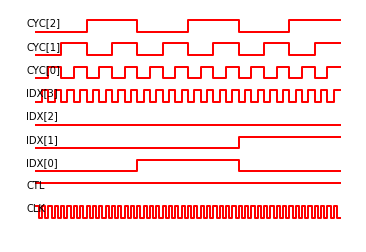

In [4]:
class Test(Circuit):
    name = "Test"
    IO = ['CLK', In(Clock), 'IDX', Out(Bits(b)), 'CYCLE', Out(Bits(n)),
          'CONTROL', Out(Bit)]
    @classmethod
    def definition(io):
        # IF
        controller = Controller()
        reg_1_cycle = mantle.DefineRegister(n)()
        reg_1_control = mantle.DFF(init=1)
        wire(io.CLK, controller.CLK)
        wire(io.CLK, reg_1_cycle.CLK)
        wire(io.CLK, reg_1_control.CLK)
        reg_1_idx = controller.IDX
        wire(controller.CYCLE, reg_1_cycle.I)
        wire(1, reg_1_control.I)
        
        wire(reg_1_idx, io.IDX)
        wire(reg_1_cycle.O, io.CYCLE)
        wire(reg_1_control.O, io.CONTROL)

simulator = PythonSimulator(Test)
scope = Scope()

waveforms = []

for i in range(96):
    simulator.step()
    simulator.evaluate()
    clk = simulator.get_value(Test.CLK, scope)
    o = simulator.get_value(Test.IDX, scope)
    c = simulator.get_value(Test.CYCLE, scope)
    ctl = simulator.get_value(Test.CONTROL, scope)
    waveforms.append([clk, ctl] + o + c)
names = ["CLK", "CTL"]
for i in range(n):
    names.append("IDX[{}]".format(i))
for i in range(b):
    names.append("CYC[{}]".format(i))
from magma.waveform import waveform
waveform(waveforms, names)

## ROM module

Test Unit for Rom Reading

In [4]:
class TestReadRom2(Circuit):
    name = "TestReadRom2"
    IO = ['IDX', In(Bits(b)), 'CYCLE', In(Bits(n)), 'CLK', In(Clock),
          'WEIGHT', Out(Bits(N)), 'IMAGE', Out(Bits(N))]
    @classmethod
    def definition(io):
        weights_list = [1] + [2**16-1]*15 + [3] + [2**16-1]*15 + ([0] + [2**16-1]*15)*((256-32)//16)
        weigths_rom = ROMB(weights_list)
        lut_list = []
        for i in range(N):
            lut_list.append(SB_LUT4(LUT_INIT=1))
        wire(io.CYCLE, weigths_rom.RADDR[:n])
        wire(io.IDX, weigths_rom.RADDR[n:n+b])
        if n + b < 8:
            wire(int2seq(0, 8-n-b), weigths_rom.RADDR[n+b:])
        wire(1, weigths_rom.RE)
        wire(weigths_rom.RDATA, io.WEIGHT)
        wire(io.CLK, weigths_rom.RCLK)
        for i in range(N):
            wire(io.CYCLE, [lut_list[i].I0, lut_list[i].I1, lut_list[i].I2, lut_list[i].I3])
            wire(lut_list[i].O, io.IMAGE[i])

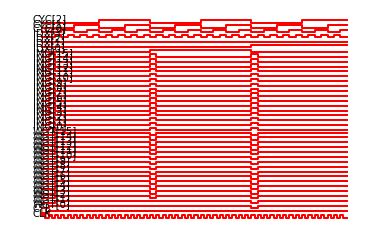

In [5]:
class Test(Circuit):
    name = "Test"
    IO = ['CLK', In(Clock), 'WEIGHT', Out(Bits(N)), 'IMAGE', Out(Bits(N)),
          'IDX', Out(Bits(b)), 'CYCLE', Out(Bits(n)), 'CONTROL', Out(Bit)]
    @classmethod
    def definition(io):
        # IF - get cycle_id, label_index_id
        controller = Controller()
        reg_1_cycle = mantle.DefineRegister(n)()
        reg_1_control = mantle.DFF(init=1)
        wire(io.CLK, controller.CLK)
        wire(io.CLK, reg_1_cycle.CLK)
        wire(io.CLK, reg_1_control.CLK)
        reg_1_idx = controller.IDX
        wire(controller.CYCLE, reg_1_cycle.I)
        wire(1, reg_1_control.I)
        # RR - get weight block, image block of N bits
        readROM = TestReadRom2()
        wire(reg_1_idx, readROM.IDX)
        wire(reg_1_cycle.O, readROM.CYCLE)
        reg_2 = mantle.DefineRegister(N + b + n)()
        reg_2_control = mantle.DFF()
        reg_2_weight = readROM.WEIGHT
        wire(io.CLK, reg_2.CLK)
        wire(io.CLK, readROM.CLK)
        wire(io.CLK, reg_2_control.CLK)
        wire(readROM.IMAGE, reg_2.I[:N])
        wire(reg_1_idx, reg_2.I[N:N + b])
        wire(reg_1_cycle.O, reg_2.I[N + b:])
        wire(reg_1_control.O, reg_2_control.I)
        
        wire(reg_2_weight, io.WEIGHT)
        wire(reg_2.O[:N], io.IMAGE)
        wire(reg_2.O[N:N+b], io.IDX)
        wire(reg_2.O[N+b:], io.CYCLE)
        wire(reg_2_control.O, io.CONTROL)

simulator = PythonSimulator(Test)
scope = Scope()

waveforms = []

for i in range(96):
    simulator.step()
    simulator.evaluate()
    clk = simulator.get_value(Test.CLK, scope)
    w = simulator.get_value(Test.WEIGHT, scope)
    i = simulator.get_value(Test.IMAGE, scope)
    d = simulator.get_value(Test.IDX, scope)
    c = simulator.get_value(Test.CYCLE, scope)
    ctl = simulator.get_value(Test.CONTROL, scope)
    waveforms.append([clk, ctl] + w + i + d + c)
names = ["CLK", "CTL"]
for i in range(N):
    names.append("WGT[{}]".format(i))
for i in range(N):
    names.append("IMG[{}]".format(i))
for i in range(n):
    names.append("IDX[{}]".format(i))
for i in range(b):
    names.append("CYC[{}]".format(i))
from magma.waveform import waveform
waveform(waveforms, names)

## Pop Count Unit
4/8/16 bit pop count

In [5]:
# 4-bit pop count
class BitCounter4(Circuit):
    name = "BitCounter4"
    IO = ['I', In(Bits(4)), 'O', Out(Bits(3))]
    @classmethod
    def definition(io):
        lut_list = []
        lut_list.append(SB_LUT4(LUT_INIT=int('0110100110010110', 2)))
        lut_list.append(SB_LUT4(LUT_INIT=int('0111111011101000', 2)))
        lut_list.append(SB_LUT4(LUT_INIT=int('1000000000000000', 2)))
        for i in range(3):
            wire(io.I, [lut_list[i].I0, lut_list[i].I1, lut_list[i].I2, lut_list[i].I3])
            wire(lut_list[i].O, io.O[i])


# 8-bit pop count
class BitCounter8(Circuit):
    name = "BitCounter8"
    IO = ['I', In(Bits(8)), 'O', Out(Bits(4))]
    @classmethod
    def definition(io):
        counter_1 = BitCounter4()
        counter_2 = BitCounter4()
        wire(io.I[:4], counter_1.I)
        wire(io.I[4:], counter_2.I)
        adders = [mantle.HalfAdder()] + [mantle.FullAdder() for _ in range(2)]
        for i in range(3):
            wire(counter_1.O[i], adders[i].I0)
            wire(counter_2.O[i], adders[i].I1)
            if i > 0:
                wire(adders[i-1].COUT, adders[i].CIN)
            wire(adders[i].O, io.O[i])
        wire(adders[-1].COUT, io.O[-1])


# 16-bit pop count
class BitCounter16(Circuit):
    name = 'BitCounter16'
    IO = ['I', In(Bits(16)), 'O', Out(Bits(5))]
    @classmethod
    def definition(io):
        counter_1 = BitCounter8()
        counter_2 = BitCounter8()
        wire(io.I[:8], counter_1.I)
        wire(io.I[8:], counter_2.I)
        adders = [mantle.HalfAdder()] + [mantle.FullAdder() for _ in range(3)]
        for i in range(4):
            wire(counter_1.O[i], adders[i].I0)
            wire(counter_2.O[i], adders[i].I1)
            if i > 0:
                wire(adders[i-1].COUT, adders[i].CIN)
            wire(adders[i].O, io.O[i])
        wire(adders[-1].COUT, io.O[-1])


# pop count
def DefineBitCounter(n):
    if n <= 4:
        return BitCounter4
    elif n <= 8:
        return BitCounter8
    elif n <= 16:
        return BitCounter16
    else:
        return None

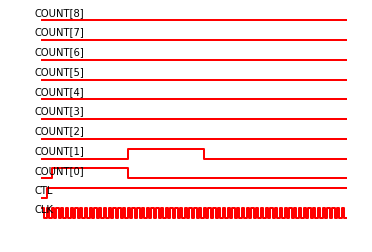

In [6]:
class Test(Circuit):
    name = "Test"
    IO = ['CLK', In(Clock), 'COUNT', Out(Bits(n_bc_adder)), 'CONTROL', Out(Bit)]
    @classmethod
    def definition(io):
        # IF - get cycle_id, label_index_id
        controller = Controller()
        reg_1_cycle = mantle.DefineRegister(n)()
        reg_1_control = mantle.DFF(init=1)
        wire(io.CLK, controller.CLK)
        wire(io.CLK, reg_1_cycle.CLK)
        wire(io.CLK, reg_1_control.CLK)
        reg_1_idx = controller.IDX
        wire(controller.CYCLE, reg_1_cycle.I)
        wire(1, reg_1_control.I)
        # RR - get weight block, image block of N bits
        readROM = TestReadRom2()
        wire(reg_1_idx, readROM.IDX)
        wire(reg_1_cycle.O, readROM.CYCLE)
        reg_2 = mantle.DefineRegister(N + b + n)()
        reg_2_control = mantle.DFF()
        reg_2_weight = readROM.WEIGHT
        wire(io.CLK, reg_2.CLK)
        wire(io.CLK, readROM.CLK)
        wire(io.CLK, reg_2_control.CLK)
        wire(readROM.IMAGE, reg_2.I[:N])
        wire(reg_1_idx, reg_2.I[N:N + b])
        wire(reg_1_cycle.O, reg_2.I[N + b:])
        wire(reg_1_control.O, reg_2_control.I)
        # EX - NXOr for multiplication, pop count and accumulate the result for activation
        multiplier = mantle.NXOr(height=2, width=N)
        bit_counter = DefineBitCounter(N)()
        adder = mantle.DefineAdders(n_bc_adder, cin=False, cout=False)()
        mux_for_adder_0 = mantle.DefineMux(height=2, width=n_bc_adder)()
        mux_for_adder_1 = mantle.DefineMux(height=2, width=n_bc_adder)()
        reg_3_1 = mantle.DefineRegister(n_bc_adder)()
        reg_3_2 = mantle.DefineRegister(b + n)()
        wire(io.CLK, reg_3_1.CLK)
        wire(io.CLK, reg_3_2.CLK)
        wire(reg_2_weight, multiplier.I0)
        wire(reg_2.O[:N], multiplier.I1)
        wire(multiplier.O, bit_counter.I)
        wire(int2seq(0, n_bc_adder), mux_for_adder_0.I0)
        wire(bit_counter.O, mux_for_adder_0.I1[:n_bc])
        if n_bc_adder > n_bc:
            wire(int2seq(0, n_bc_adder - n_bc), mux_for_adder_0.I1[n_bc:])
        # only when data read is ready (i.e. control signal is high), accumulate the pop count result
        wire(reg_2_control.O, mux_for_adder_0.S)
        wire(reg_3_1.O, mux_for_adder_1.I0)
        wire(int2seq(0, n_bc_adder), mux_for_adder_1.I1)
        if n == 4:
            comparison_3 = SB_LUT4(LUT_INIT=int('0'*15+'1', 2))
            wire(reg_2.O[N+b:], [comparison_3.I0, comparison_3.I1, comparison_3.I2, comparison_3.I3])
        else:
            comparison_3 = mantle.EQ(n)
            wire(reg_2.O[N+b:], comparison_3.I0)
            wire(int2seq(0, n), comparison_3.I1)
        wire(comparison_3.O, mux_for_adder_1.S)
        wire(mux_for_adder_0.O, adder.I0)
        wire(mux_for_adder_1.O, adder.I1)
        wire(adder.O, reg_3_1.I)
        wire(reg_2.O[N:], reg_3_2.I)

        wire(reg_3_1.O, io.COUNT)
        wire(reg_2_control.O, io.CONTROL)

simulator = PythonSimulator(Test)
scope = Scope()

waveforms = []

for i in range(128):
    simulator.step()
    simulator.evaluate()
    clk = simulator.get_value(Test.CLK, scope)
    o = simulator.get_value(Test.COUNT, scope)
    ctl = simulator.get_value(Test.CONTROL, scope)
    waveforms.append([clk, ctl] + o)
names = ["CLK", "CTL"]
for i in range(n_bc_adder):
    names.append("COUNT[{}]".format(i))
from magma.waveform import waveform
waveform(waveforms, names)

## Classifier Module

using compare operation to decide the final prediction label of image

In [6]:
class Classifier(Circuit):
    name = "Classifier"
    IO = ['I', In(Bits(n_bc_adder)), 'IDX', In(Bits(b)), 'CLK', In(Clock),
          'O', Out(Bits(b)), 'M', Out(Bits(n_bc_adder))]
    @classmethod
    def definition(io):
        comparison = mantle.UGT(n_bc_adder)
        reg_count = mantle.DefineRegister(n_bc_adder, has_ce=True)()
        reg_idx = mantle.DefineRegister(b, has_ce=True)()
        wire(io.I, comparison.I0)
        wire(reg_count.O, comparison.I1)
        wire(comparison.O, reg_count.CE)
        wire(comparison.O, reg_idx.CE)
        wire(io.CLK, reg_count.CLK)
        wire(io.CLK, reg_idx.CLK)
        wire(io.I, reg_count.I)
        wire(io.IDX, reg_idx.I)
        wire(reg_idx.O, io.O)
        wire(reg_count.O, io.M)

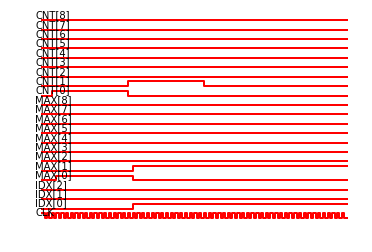

In [7]:
class Test(Circuit):
    name = "Test"
    IO = ['CLK', In(Clock), 'MAX', Out(Bits(n_bc_adder)),
          'IDX', Out(Bits(b)), 'COUNT', Out(Bits(n_bc_adder))]
    @classmethod
    def definition(io):
        # IF - get cycle_id, label_index_id
        controller = Controller()
        reg_1_cycle = mantle.DefineRegister(n)()
        reg_1_control = mantle.DFF(init=1)
        wire(io.CLK, controller.CLK)
        wire(io.CLK, reg_1_cycle.CLK)
        wire(io.CLK, reg_1_control.CLK)
        reg_1_idx = controller.IDX
        wire(controller.CYCLE, reg_1_cycle.I)
        wire(1, reg_1_control.I)
        # RR - get weight block, image block of N bits
        readROM = TestReadRom2()
        wire(reg_1_idx, readROM.IDX)
        wire(reg_1_cycle.O, readROM.CYCLE)
        reg_2 = mantle.DefineRegister(N + b + n)()
        reg_2_control = mantle.DFF()
        reg_2_weight = readROM.WEIGHT
        wire(io.CLK, reg_2.CLK)
        wire(io.CLK, readROM.CLK)
        wire(io.CLK, reg_2_control.CLK)
        wire(readROM.IMAGE, reg_2.I[:N])
        wire(reg_1_idx, reg_2.I[N:N + b])
        wire(reg_1_cycle.O, reg_2.I[N + b:])
        wire(reg_1_control.O, reg_2_control.I)
        # EX - NXOr for multiplication, pop count and accumulate the result for activation
        multiplier = mantle.NXOr(height=2, width=N)
        bit_counter = DefineBitCounter(N)()
        adder = mantle.DefineAdders(n_bc_adder, cin=False, cout=False)()
        mux_for_adder_0 = mantle.DefineMux(height=2, width=n_bc_adder)()
        mux_for_adder_1 = mantle.DefineMux(height=2, width=n_bc_adder)()
        reg_3_1 = mantle.DefineRegister(n_bc_adder)()
        reg_3_2 = mantle.DefineRegister(b + n)()
        wire(io.CLK, reg_3_1.CLK)
        wire(io.CLK, reg_3_2.CLK)
        wire(reg_2_weight, multiplier.I0)
        wire(reg_2.O[:N], multiplier.I1)
        wire(multiplier.O, bit_counter.I)
        wire(int2seq(0, n_bc_adder), mux_for_adder_0.I0)
        wire(bit_counter.O, mux_for_adder_0.I1[:n_bc])
        if n_bc_adder > n_bc:
            wire(int2seq(0, n_bc_adder - n_bc), mux_for_adder_0.I1[n_bc:])
        # only when data read is ready (i.e. control signal is high), accumulate the pop count result
        wire(reg_2_control.O, mux_for_adder_0.S)
        wire(reg_3_1.O, mux_for_adder_1.I0)
        wire(int2seq(0, n_bc_adder), mux_for_adder_1.I1)
        if n == 4:
            comparison_3 = SB_LUT4(LUT_INIT=int('0'*15+'1', 2))
            wire(reg_2.O[N+b:], [comparison_3.I0, comparison_3.I1, comparison_3.I2, comparison_3.I3])
        else:
            comparison_3 = mantle.EQ(n)
            wire(reg_2.O[N+b:], comparison_3.I0)
            wire(int2seq(0, n), comparison_3.I1)
        wire(comparison_3.O, mux_for_adder_1.S)
        wire(mux_for_adder_0.O, adder.I0)
        wire(mux_for_adder_1.O, adder.I1)
        wire(adder.O, reg_3_1.I)
        wire(reg_2.O[N:], reg_3_2.I)
        # CF - classify the image
        classifier = Classifier()
        reg_4 = mantle.DefineRegister(n + b)()
        reg_4_idx = classifier.O
        wire(io.CLK, classifier.CLK)
        wire(io.CLK, reg_4.CLK)
        wire(reg_3_1.O, classifier.I)
        wire(reg_3_2.O[:b], classifier.IDX)
        wire(reg_3_2.O, reg_4.I)
        
        wire(reg_3_1.O, io.COUNT)
        wire(classifier.O, io.IDX)
        wire(classifier.M, io.MAX)

simulator = PythonSimulator(Test)
scope = Scope()

waveforms = []

for i in range(128):
    simulator.step()
    simulator.evaluate()
    clk = simulator.get_value(Test.CLK, scope)
    o = simulator.get_value(Test.IDX, scope)
    m = simulator.get_value(Test.MAX, scope)
    c = simulator.get_value(Test.COUNT, scope)
    waveforms.append([clk] + o + m + c)
names = ["CLK"]
for i in range(b):
    names.append("IDX[{}]".format(i))
for i in range(n_bc_adder):
    names.append("MAX[{}]".format(i))
for i in range(n_bc_adder):
    names.append("CNT[{}]".format(i))
from magma.waveform import waveform
waveform(waveforms, names)

In [6]:
class Classifier(Circuit):
    name = "Classifier"
    IO = ['I', In(Bits(n_bc_adder)), 'IDX', In(Bits(b)), 'CLK', In(Clock), 'O', Out(Bits(b))]
    @classmethod
    def definition(io):
        comparison = mantle.UGT(n_bc_adder)
        reg_count = mantle.DefineRegister(n_bc_adder, has_ce=True)()
        reg_idx = mantle.DefineRegister(b, has_ce=True)()
        wire(io.I, comparison.I0)
        wire(reg_count.O, comparison.I1)
        wire(comparison.O, reg_count.CE)
        wire(comparison.O, reg_idx.CE)
        wire(io.CLK, reg_count.CLK)
        wire(io.CLK, reg_idx.CLK)
        wire(io.I, reg_count.I)
        wire(io.IDX, reg_idx.I)
        wire(reg_idx.O, io.O)

## Pipeline Module

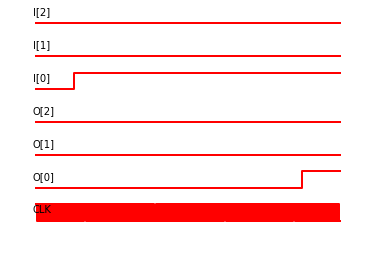

In [7]:
class Test(Circuit):
    name = "Test"
    IO = ['CLK', In(Clock), 'O', Out(Bits(b)), 'IDX', Out(Bits(b))]
    @classmethod
    def definition(io):
        # IF - get cycle_id, label_index_id
        controller = Controller()
        reg_1_cycle = mantle.DefineRegister(n)()
        reg_1_control = mantle.DFF(init=1)
        wire(io.CLK, controller.CLK)
        wire(io.CLK, reg_1_cycle.CLK)
        wire(io.CLK, reg_1_control.CLK)
        reg_1_idx = controller.IDX
        wire(controller.CYCLE, reg_1_cycle.I)
        wire(1, reg_1_control.I)
        # RR - get weight block, image block of N bits
        readROM = TestReadRom2()
        wire(reg_1_idx, readROM.IDX)
        wire(reg_1_cycle.O, readROM.CYCLE)
        reg_2 = mantle.DefineRegister(N + b + n)()
        reg_2_control = mantle.DFF()
        reg_2_weight = readROM.WEIGHT
        wire(io.CLK, reg_2.CLK)
        wire(io.CLK, readROM.CLK)
        wire(io.CLK, reg_2_control.CLK)
        wire(readROM.IMAGE, reg_2.I[:N])
        wire(reg_1_idx, reg_2.I[N:N + b])
        wire(reg_1_cycle.O, reg_2.I[N + b:])
        wire(reg_1_control.O, reg_2_control.I)
        # EX - NXOr for multiplication, pop count and accumulate the result for activation
        multiplier = mantle.NXOr(height=2, width=N)
        bit_counter = DefineBitCounter(N)()
        adder = mantle.DefineAdders(n_bc_adder, cin=False, cout=False)()
        mux_for_adder_0 = mantle.DefineMux(height=2, width=n_bc_adder)()
        mux_for_adder_1 = mantle.DefineMux(height=2, width=n_bc_adder)()
        reg_3_1 = mantle.DefineRegister(n_bc_adder)()
        reg_3_2 = mantle.DefineRegister(b + n)()
        wire(io.CLK, reg_3_1.CLK)
        wire(io.CLK, reg_3_2.CLK)
        wire(reg_2_weight, multiplier.I0)
        wire(reg_2.O[:N], multiplier.I1)
        wire(multiplier.O, bit_counter.I)
        wire(int2seq(0, n_bc_adder), mux_for_adder_0.I0)
        wire(bit_counter.O, mux_for_adder_0.I1[:n_bc])
        if n_bc_adder > n_bc:
            wire(int2seq(0, n_bc_adder - n_bc), mux_for_adder_0.I1[n_bc:])
        # only when data read is ready (i.e. control signal is high), accumulate the pop count result
        wire(reg_2_control.O, mux_for_adder_0.S)
        wire(reg_3_1.O, mux_for_adder_1.I0)
        wire(int2seq(0, n_bc_adder), mux_for_adder_1.I1)
        if n == 4:
            comparison_3 = SB_LUT4(LUT_INIT=int('0'*15+'1', 2))
            wire(reg_2.O[N+b:], [comparison_3.I0, comparison_3.I1, comparison_3.I2, comparison_3.I3])
        else:
            comparison_3 = mantle.EQ(n)
            wire(reg_2.O[N+b:], comparison_3.I0)
            wire(int2seq(0, n), comparison_3.I1)
        wire(comparison_3.O, mux_for_adder_1.S)
        wire(mux_for_adder_0.O, adder.I0)
        wire(mux_for_adder_1.O, adder.I1)
        wire(adder.O, reg_3_1.I)
        wire(reg_2.O[N:], reg_3_2.I)
        # CF - classify the image
        classifier = Classifier()
        reg_4 = mantle.DefineRegister(n + b)()
        reg_4_idx = classifier.O
        wire(io.CLK, classifier.CLK)
        wire(io.CLK, reg_4.CLK)
        wire(reg_3_1.O, classifier.I)
        wire(reg_3_2.O[:b], classifier.IDX)
        wire(reg_3_2.O, reg_4.I)
        # WB - wait to show the result until the end
        reg_5 = mantle.DefineRegister(b, has_ce=True)()
        comparison_5_1 = mantle.EQ(b)
        comparison_5_2 = mantle.EQ(n)
        and_gate = mantle.And()
        wire(io.CLK, reg_5.CLK)
        wire(reg_4_idx, reg_5.I)
        wire(reg_4.O[:b], comparison_5_1.I0)
        wire(int2seq(num_classes - 1, b), comparison_5_1.I1)
        wire(reg_4.O[b:], comparison_5_2.I0)
        wire(int2seq(num_cycles - 1, n), comparison_5_2.I1)
        wire(comparison_5_1.O, and_gate.I0)
        wire(comparison_5_2.O, and_gate.I1)
        wire(and_gate.O, reg_5.CE)
        wire(reg_5.O, io.O)
        
        wire(classifier.O, io.IDX)


simulator = PythonSimulator(Test)
scope = Scope()

waveforms = []

for i in range(300):
    simulator.step()
    simulator.evaluate()
    clk = simulator.get_value(Test.CLK, scope)
    o = simulator.get_value(Test.O, scope)
    i = simulator.get_value(Test.IDX, scope)
    waveforms.append([clk] + o + i)
names = ["CLK"]
for i in range(b):
    names.append("O[{}]".format(i))
for i in range(b):
    names.append("I[{}]".format(i))
from magma.waveform import waveform
waveform(waveforms, names)